# Decision Trees in Scikit-Learn

The `DecisionTreeClassifier` class in `sklearn.tree` provides a decision tree classifier. Its implementation is based on the CART (Classification and Regression Trees) algorithm. However, it currently does not support categorical features, so we will need to convert categorical variables into numerical ones before training the model (e.g., by using OneHotEncoder).

Let's train a decision tree classifier on the [Iris data set](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html), but using only the first two features of each flower (the sepal length and sepal width), which makes this classification problem more challenging.

In [31]:
from matplotlib.colors import ListedColormap

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Iris Dataset

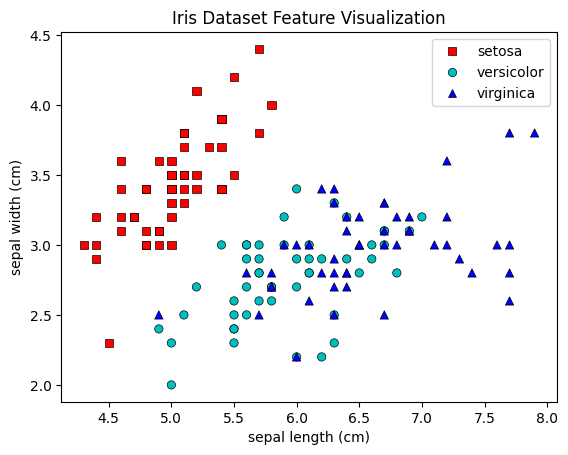

In [34]:
iris = load_iris()

# take the first two features
X = iris.data[:, :2]
y = iris.target

feature_names = iris.feature_names[:2]
target_names = iris.target_names

sns.scatterplot(
    x=X[:, 0], 
    y=X[:, 1], 
    hue=target_names[y], 
    style=target_names[y], 
    palette=['r', 'c', 'b'], 
    markers=('s', 'o', '^'), 
    edgecolor='k'
)

plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Iris Dataset Feature Visualization')
plt.show()

In this data set we don’t need to perform any data preprocessing, since all our features are numerical, and **decision trees don’t require scaling (normalization).**

## Test Train Split and Classifier

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [13]:
print(f'Train accuracy: {clf.score(X_train, y_train):.4f}')
print(f'Test accuracy: {clf.score(X_test, y_test):.4f}')

Train accuracy: 0.9554
Test accuracy: 0.6579


In [17]:
def plot_decision_boundaries(clf, X, y, feature_names, class_names, 
                             colors=['r', 'c', 'b'], markers=('s', 'o', '^')):  
    
    cmap = ListedColormap(colors)
      
    # create a mesh of n sample points in the range [x1_min, x1_max] x [x2_min, x2_max]
    n = 1000 
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1 
    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, n), np.linspace(x2_min, x2_max, n))
    
    # find the label of each point in the mesh
    y_pred = clf.predict(np.c_[x1.ravel(), x2.ravel()])
    y_pred = y_pred.reshape(x1.shape) 
    
    # put the result into a color plot  
    plt.contourf(x1, x2, y_pred, cmap=cmap, alpha=0.4)
    
    # plot the points from the data set
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=class_names[y], style=class_names[y], 
                    palette=colors, markers=markers, edgecolor='k')
    
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.legend()

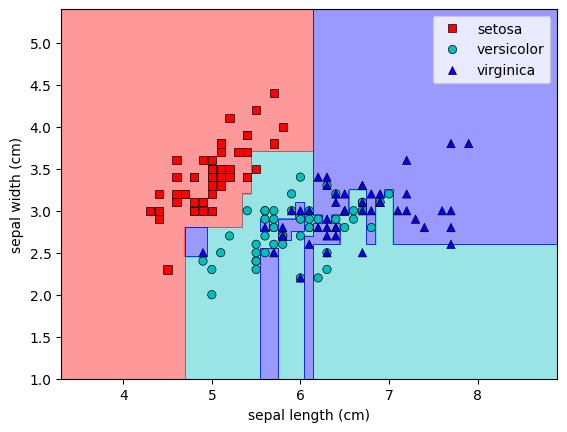

In [18]:
plot_decision_boundaries(clf, X, y, iris.feature_names, iris.target_names)

## Tree Pruning
The main problem in decision trees is overfitting. On one hand, decision trees are one of the very few machine learning models that can achieve 100% accuracy on the training set (unless we have two samples with exactly the same attribute values but different labels). On the other hand, decision trees are prone to overfitting, since they try to adapt themselves to every single example in the training set, and thus they usually have poor performance on the test set.

The main technique to deal with overfitting in decision trees is by using pruning. There are two types of pruning: pre-pruning and post-pruning, which will be described next.

### Pre-Pruning
In pre-pruning, we stop the tree construction early, before it produces leaf nodes with very small numbers of samples.
- Maximum depth of the tree `(max_depth)`. The tree building stops when the tree reaches the specified depth.
- Minimum number of samples in a leaf `(min_samples_leaf)`. A node will be split only if it leaves at least this number of training samples in each of the left and right child nodes.
- Minimum number of samples required to split a node `(min_samples_split, defaults to 2)`.
- Maximum number of leaf nodes `(max_leaf_nodes)`. The tree is grown in best-first fashion (with respect to the reduction in the impurity measure) until the number of maximum leaf nodes is reached.
- Minimum impurity decrease `(min_impurity_decrease)`. A node is split only if this split induces a decrease of the impurity greater than or equal to this value.

### Post-Pruning
In post-pruning, we first grow the decision tree to its entirety, and then we trim the nodes of the tree in a bottom-up fashion. Each trimmed node is replaced by a leaf node, whose class label is determined by the majority class of the samples in its subtree. We keep trimming the nodes as long as the generalization error improves.

In [19]:
# Pre-pruning: limit the depth of the decision tree to 3

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [20]:
print(f'Train accuracy: {clf.score(X_train, y_train):.4f}')
print(f'Test accuracy: {clf.score(X_test, y_test):.4f}')

Train accuracy: 0.8214
Test accuracy: 0.7632


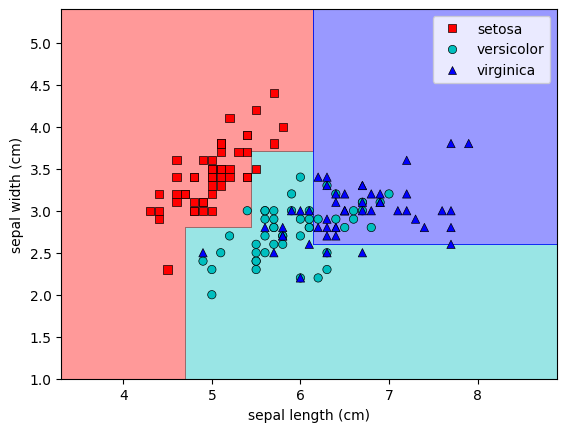

In [21]:
plot_decision_boundaries(clf, X, y, iris.feature_names, iris.target_names)

# Regression Trees
Decision trees can also be used for regression tasks, in which case they are often called regression trees.

In regression trees, a common criteria that is used to determine the best split in a given node is MSE (Mean Squared Error), i.e., the average squared difference between the actual target values in a given node and the predicted value at that node:

$$\text{MSE(v)} = \frac{1}{n} \sum_{(x_i, y_i) \in v} (y_i - \hat{y}) ^2$$

where $n$ is the number of samples at node $v$.

The predicted value is typically chosen as the mean of the target values at the node, i.e.,

$$\hat{y} = \bar{y} = \frac{1}{n} \sum_{(x_i, y_i) \in v} y_i$$

In this case, the MSE is the same as the variance of the target values within the node, since it is equal to the average squared difference between the target values and their mean. The variance is a good indicator for the impurity of the labels. A lower variance means that the target values are closer to each other, therefore we can be more certain about the correct label of that node. Similar to classification trees, in every node we choose the attribute that leads to the highest reduction in the variance.

In [26]:
from sklearn.datasets import fetch_california_housing
from sklearn.tree import DecisionTreeRegressor

In [24]:
data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names

This data set contains only numerical features and has no missing values, so there is no need for any data pre-processing.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

reg = DecisionTreeRegressor(random_state=0)
reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [28]:
train_score = reg.score(X_train, y_train)
print(f'R2 score (train): {train_score:.4f}')

test_score = reg.score(X_test, y_test)
print(f'R2 score (test): {test_score:.4f}')

R2 score (train): 1.0000
R2 score (test): 0.5924


The model got a perfect $R^2$ score on the training set! However, this tree is badly overfitting, and thus has a poor score on the test set.

Let’s run a grid search on some of the pre-pruning parameters in order to find a tree with a better generalization score:

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': np.arange(5, 16),
    'min_samples_leaf': np.arange(2, 11),
}

grid = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

{'max_depth': 13, 'min_samples_leaf': 10}


In [30]:
train_score = grid.score(X_train, y_train)
print(f'R2 score (train): {train_score:.4f}')

test_score = grid.score(X_test, y_test)
print(f'R2 score (test): {test_score:.4f}')

R2 score (train): 0.8485
R2 score (test): 0.7188
